<a href="https://colab.research.google.com/github/Bovi-analytics/hut-et-al-2021/blob/master/WalkingTime_MonthsInMilk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical notebook for walking time MonthsInMilk

## Importing of google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## R loading

In [ ]:
%reload_ext rpy2.ipython

In [ ]:
%%R
lib_loc <- "/content/drive/Shareddrives/Bovi-Analytics/R-lib/"

In [ ]:
%%R
package_list <- c("ggplot2",
                  "readr",
                  "plyr",
                  "dplyr",
                  "tidyr",                
                  "lme4",
                  "lmerTest",
                  "multcompView",
                  "mvtnorm",
                  "TH.data",
                  "multcomp",
                  "emmeans",
                  "lsmeans",
                  "carData",
                  "car"
                  )

for (pkg in package_list) {
  if (pkg %in% rownames(.packages()) == FALSE)
  {library(pkg, lib.loc = lib_loc, character.only = TRUE)}

}

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step


R[write to console]: Loading required package: survival

R[write to console]: Loading required package: MASS

R[write to console]: 
Attaching

## Data loading into dataframe

In [ ]:
%%R
url = ('/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned02042021/ObservationType=WalkingTimePerDay/part-00000-tid-1349821109549544597-c9251edd-6d65-49bf-bc6f-941ced55eb0c-3065-39.c000.csv')

dataset = read.csv(url)



In [ ]:
%%R

#path <- "/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned08032021/ObservationType=WalkingTimeMinutesPer2Hours/part-00000-tid-5876581890551720600-0e9afc0a-339b-4a8d-9159-2f92fdf60451-17582-38.c000.csv"
AnalysisData <- 
  readr::read_csv("/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned02042021/ObservationType=WalkingTimePerDay/part-00000-tid-1349821109549544597-c9251edd-6d65-49bf-bc6f-941ced55eb0c-3065-39.c000.csv", 
    col_types = readr::cols(HerdIdentifier = readr::col_character(), 
        TransitionLactationNumber = readr::col_integer(), 
        TransitionParity = readr::col_character(), 
        TransitionMonthsInMilk = readr::col_integer(), 
        TransitionCalvingDate = readr::col_character(), 
        Hour = readr::col_integer(), 
        Observations = readr::col_integer())) %>% 
  dplyr::filter(dplyr::between(TransitionMonthsInMilk, -1, 10)) %>%
   dplyr::mutate(
    AnimalIdentifier = factor(AnimalIdentifier),
    HerdIdentifier = factor(HerdIdentifier),
    Parity = factor(TransitionParity),
    MonthsInMilk = factor(TransitionMonthsInMilk),
    CalvingSeason = factor(TransitionSeason),
    Hour = factor(Hour),
    SensorValue = ObservationValue,
    MilkingType = factor(case_when(
    HerdIdentifier %in% c("544", "2514", "3314")~"AMS",
    TRUE~"CMS"
  ))
  ) %>%
  dplyr::select(AnimalIdentifier, HerdIdentifier, Parity, MonthsInMilk, CalvingSeason, Hour, SensorValue, MilkingType) %>%
  tidyr::drop_na()

In [ ]:
%%R
head(AnalysisData)

# A tibble: 6 x 8
  AnimalIdentifier HerdIdentifier Parity MonthsInMilk CalvingSeason Hour 
  <fct>            <fct>          <fct>  <fct>        <fct>         <fct>
1 70               2297           1      3            Winter        22   
2 7829             2011           3+     7            Summer        23   
3 7831             2011           3+     5            Autumn        22   
4 72               2297           2      3            Winter        23   
5 71               2297           1      6            Spring        22   
6 7955             2011           3+     5            Winter        22   
# … with 2 more variables: SensorValue <dbl>, MilkingType <fct>


In [ ]:
%%R
str(AnalysisData)

tibble[,8] [54,073 × 8] (S3: tbl_df/tbl/data.frame)
 $ AnimalIdentifier: Factor w/ 1051 levels "1","2","3","4",..: 70 671 672 72 71 678 708 679 736 76 ...
 $ HerdIdentifier  : Factor w/ 8 levels "2011","2297",..: 2 1 1 2 2 1 1 1 1 2 ...
 $ Parity          : Factor w/ 3 levels "1","2","3+": 1 3 3 2 1 3 3 3 3 2 ...
 $ MonthsInMilk    : Factor w/ 12 levels "-1","0","1","2",..: 5 9 7 5 8 7 8 6 5 4 ...
 $ CalvingSeason   : Factor w/ 4 levels "Autumn","Spring",..: 4 3 1 4 2 4 2 1 3 4 ...
 $ Hour            : Factor w/ 2 levels "22","23": 1 2 1 2 1 1 1 2 1 1 ...
 $ SensorValue     : num [1:54073] 55.3 29 48.4 53.7 61.3 ...
 $ MilkingType     : Factor w/ 2 levels "AMS","CMS": 2 2 2 2 2 2 2 2 2 2 ...


## Descriptive statistics

In [ ]:
%%R
AnalysisData %>%
  group_by(Parity) %>%
  summarise(Unique_Elements = n_distinct(AnimalIdentifier))

# A tibble: 3 x 2
  Parity Unique_Elements
  <fct>            <int>
1 1                  736
2 2                  712
3 3+                 742


In [ ]:
%%R
AnalysisData %>%
  summarise(Unique_Elements = n_distinct(AnimalIdentifier))

# A tibble: 1 x 1
  Unique_Elements
            <int>
1            1051


# Model building

First we determine the null model

## Null model

In [ ]:
%%R
Model.0 <- lme4::lmer(
                  SensorValue ~ 1 + (1| HerdIdentifier:AnimalIdentifier), 
                  data = AnalysisData
                  )

## Univariable models

In [ ]:
%%R
Model1.0 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model.0,Model1.0,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.0: SensorValue ~ MonthsInMilk + (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 478271 478298 -239133   478265                         
Model1.0   14 476821 476946 -238397   476793 1472.2 11  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.1 <- lme4::lmer(
                  SensorValue ~ 
                  Parity + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.1,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.1: SensorValue ~ Parity + (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 478271 478298 -239133   478265                         
Model1.1    5 476430 476475 -238210   476420 1845.2  2  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.2 <- lme4::lmer(
                  SensorValue ~ 
                  CalvingSeason +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.2,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.2: SensorValue ~ CalvingSeason + (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance Chisq Df Pr(>Chisq)    
Model.0     3 478271 478298 -239133   478265                        
Model1.2    6 478235 478289 -239112   478223 41.91  3  4.193e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.3 <- lme4::lmer(
                  SensorValue ~ 
                  MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.3,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.3: SensorValue ~ MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 478271 478298 -239133   478265                         
Model1.3    4 477638 477674 -238815   477630 635.05  1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Multivariable models

In [ ]:
%%R
Model2.0 <- lme4::lmer(
                  SensorValue ~ 
                  Parity + MonthsInMilk + CalvingSeason + MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )

In [ ]:
%%R
drop1(Model2.0,test="Chisq")

Single term deletions

Model:
SensorValue ~ Parity + MonthsInMilk + CalvingSeason + MilkingType + 
    (1 | HerdIdentifier:AnimalIdentifier)
              npar    AIC     LRT   Pr(Chi)    
<none>             474352                      
Parity           2 476170 1821.67 < 2.2e-16 ***
MonthsInMilk    11 475756 1426.06 < 2.2e-16 ***
CalvingSeason    3 474363   16.92 0.0007356 ***
MilkingType      1 474999  648.53 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Introduction of interactions

### Interactions with MonthsInMilk

In [ ]:
%%R
Model2.1 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*Parity + CalvingSeason + MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.1,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + MilkingType + 
Model2.0:     (1 | HerdIdentifier:AnimalIdentifier)
Model2.1: SensorValue ~ MonthsInMilk * Parity + CalvingSeason + MilkingType + 
Model2.1:     (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   20 474352 474530 -237156   474312                         
Model2.1   42 474061 474434 -236988   473977 335.61 22  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.2 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*MilkingType + CalvingSeason + Parity +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.2,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + MilkingType + 
Model2.0:     (1 | HerdIdentifier:AnimalIdentifier)
Model2.2: SensorValue ~ MonthsInMilk * MilkingType + CalvingSeason + Parity + 
Model2.2:     (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   20 474352 474530 -237156   474312                         
Model2.2   31 474273 474549 -237105   474211 101.56 11  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.3 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*CalvingSeason + Parity + MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.3,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + MilkingType + 
Model2.0:     (1 | HerdIdentifier:AnimalIdentifier)
Model2.3: SensorValue ~ MonthsInMilk * CalvingSeason + Parity + MilkingType + 
Model2.3:     (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance Chisq Df Pr(>Chisq)    
Model2.0   20 474352 474530 -237156   474312                        
Model2.3   53 463507 463979 -231701   463401 10911 33  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Multiple interactions

In [ ]:
%%R
Model2.4 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*CalvingSeason + 
                  MonthsInMilk*Parity + 
                  MonthsInMilk*MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.4,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + MilkingType + 
Model2.0:     (1 | HerdIdentifier:AnimalIdentifier)
Model2.4: SensorValue ~ MonthsInMilk * CalvingSeason + MonthsInMilk * Parity + 
Model2.4:     MonthsInMilk * MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance Chisq Df Pr(>Chisq)    
Model2.0   20 474352 474530 -237156   474312                        
Model2.4   86 463008 463773 -231418   462836 11476 66  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
summary(Model2.4)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: SensorValue ~ MonthsInMilk * CalvingSeason + MonthsInMilk * Parity +  
    MonthsInMilk * MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
   Data: AnalysisData

      AIC       BIC    logLik  deviance  df.resid 
 463008.1  463773.4 -231418.1  462836.1     53987 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2651 -0.5509 -0.0968  0.4173 29.4462 

Random effects:
 Groups                          Name        Variance Std.Dev.
 HerdIdentifier:AnimalIdentifier (Intercept)  76.67    8.756  
 Residual                                    285.84   16.907  
Number of obs: 54073, groups:  HerdIdentifier:AnimalIdentifier, 1689

Fixed effects:
                                    Estimate Std. Error t value
(Intercept)                         41.47360    0.99375  41.734
MonthsInMilk0                        6.75208    1.16290   5.806
MonthsInMilk1                        7.76408    1.19765   6.483
MonthsInMilk2    

R[write to console]: 
Correlation matrix not shown by default, as p = 84 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




In [ ]:
%%R
finalModel <- Model2.4
Modeldrop <- drop1(finalModel, test="Chisq")
if("Pr(>F)" %in% colnames(Modeldrop))
{
  Pvalues <- Modeldrop$`Pr(>F)`
} else 
{
  Pvalues <- Modeldrop$`Pr(Chi)`
}
Modeldrop

Single term deletions

Model:
SensorValue ~ MonthsInMilk * CalvingSeason + MonthsInMilk * Parity + 
    MonthsInMilk * MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
                           npar    AIC     LRT   Pr(Chi)    
<none>                          463008                      
MonthsInMilk:CalvingSeason   33 473967 11024.4 < 2.2e-16 ***
MonthsInMilk:Parity          22 463444   479.4 < 2.2e-16 ***
MonthsInMilk:MilkingType     11 463083    96.8 7.641e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.5 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*CalvingSeason + 
                  MonthsInMilk*Parity + 
                  MonthsInMilk*MilkingType +
                  MonthsInMilk*MilkingType*CalvingSeason + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.5,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + MilkingType + 
Model2.0:     (1 | HerdIdentifier:AnimalIdentifier)
Model2.5: SensorValue ~ MonthsInMilk * CalvingSeason + MonthsInMilk * Parity + 
Model2.5:     MonthsInMilk * MilkingType + MonthsInMilk * MilkingType * 
Model2.5:     CalvingSeason + (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance Chisq  Df Pr(>Chisq)    
Model2.0   20 474352 474530 -237156   474312                         
Model2.5  122 460320 461406 -230038   460076 14236 102  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
summary(Model2.5)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: SensorValue ~ MonthsInMilk * CalvingSeason + MonthsInMilk * Parity +  
    MonthsInMilk * MilkingType + MonthsInMilk * MilkingType *  
    CalvingSeason + (1 | HerdIdentifier:AnimalIdentifier)
   Data: AnalysisData

      AIC       BIC    logLik  deviance  df.resid 
 460320.4  461405.9 -230038.2  460076.4     53951 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5925 -0.4953 -0.0768  0.3685 30.3315 

Random effects:
 Groups                          Name        Variance Std.Dev.
 HerdIdentifier:AnimalIdentifier (Intercept)  77.28    8.791  
 Residual                                    271.17   16.467  
Number of obs: 54073, groups:  HerdIdentifier:AnimalIdentifier, 1689

Fixed effects:
                                                  Estimate Std. Error t value
(Intercept)                                        38.3054     1.1650  32.881
MonthsInMilk0                                      10.1448     1.3

R[write to console]: 
Correlation matrix not shown by default, as p = 120 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




In [ ]:
%%R
Model2.6 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*CalvingSeason + 
                  MonthsInMilk*Parity + 
                  MonthsInMilk*MilkingType +
                  MonthsInMilk*MilkingType*CalvingSeason + 
                  MonthsInMilk*Parity*MilkingType*CalvingSeason +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.6,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + MilkingType + 
Model2.0:     (1 | HerdIdentifier:AnimalIdentifier)
Model2.6: SensorValue ~ MonthsInMilk * CalvingSeason + MonthsInMilk * Parity + 
Model2.6:     MonthsInMilk * MilkingType + MonthsInMilk * MilkingType * 
Model2.6:     CalvingSeason + MonthsInMilk * Parity * MilkingType * CalvingSeason + 
Model2.6:     (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance Chisq  Df Pr(>Chisq)    
Model2.0   20 474352 474530 -237156   474312                         
Model2.6  290 460155 462735 -229787   459575 14738 270  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
summary(Model2.6)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: SensorValue ~ MonthsInMilk * CalvingSeason + MonthsInMilk * Parity +  
    MonthsInMilk * MilkingType + MonthsInMilk * MilkingType *  
    CalvingSeason + MonthsInMilk * Parity * MilkingType * CalvingSeason +  
    (1 | HerdIdentifier:AnimalIdentifier)
   Data: AnalysisData

      AIC       BIC    logLik  deviance  df.resid 
 460154.6  462735.0 -229787.3  459574.6     53783 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.7410 -0.4923 -0.0752  0.3676 30.4554 

Random effects:
 Groups                          Name        Variance Std.Dev.
 HerdIdentifier:AnimalIdentifier (Intercept)  77.57    8.807  
 Residual                                    268.57   16.388  
Number of obs: 54073, groups:  HerdIdentifier:AnimalIdentifier, 1689

Fixed effects:
                                                            Estimate Std. Error
(Intercept)                                                 34.26860    2.57682
Mo

R[write to console]: 
Correlation matrix not shown by default, as p = 288 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




In [ ]:
%%R
finalModel <- Model2.5
Modeldrop <- drop1(finalModel, test="Chisq")
if("Pr(>F)" %in% colnames(Modeldrop))
{
  Pvalues <- Modeldrop$`Pr(>F)`
} else 
{
  Pvalues <- Modeldrop$`Pr(Chi)`
}
Modeldrop

Single term deletions

Model:
SensorValue ~ MonthsInMilk * CalvingSeason + MonthsInMilk * Parity + 
    MonthsInMilk * MilkingType + MonthsInMilk * MilkingType * 
    CalvingSeason + (1 | HerdIdentifier:AnimalIdentifier)
                                       npar    AIC     LRT   Pr(Chi)    
<none>                                      460320                      
MonthsInMilk:Parity                      22 460817  540.31 < 2.2e-16 ***
MonthsInMilk:CalvingSeason:MilkingType   33 463003 2748.63 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
finalModel <- Model2.6
Modeldrop <- drop1(finalModel, test="Chisq")
if("Pr(>F)" %in% colnames(Modeldrop))
{
  Pvalues <- Modeldrop$`Pr(>F)`
} else 
{
  Pvalues <- Modeldrop$`Pr(Chi)`
}
Modeldrop

Single term deletions

Model:
SensorValue ~ MonthsInMilk * CalvingSeason + MonthsInMilk * Parity + 
    MonthsInMilk * MilkingType + MonthsInMilk * MilkingType * 
    CalvingSeason + MonthsInMilk * Parity * MilkingType * CalvingSeason + 
    (1 | HerdIdentifier:AnimalIdentifier)
                                              npar    AIC    LRT   Pr(Chi)    
<none>                                             460155                     
MonthsInMilk:CalvingSeason:Parity:MilkingType   66 460154 131.79 2.771e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
save(finalModel, file="/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned08032021/finalmodelwalkingtime.rdata")

# Final model analysis of variance

In [ ]:
%%R
Anova(finalModel)

Analysis of Deviance Table (Type II Wald chisquare tests)

Response: SensorValue
                                                  Chisq Df Pr(>Chisq)    
MonthsInMilk                                   1896.796 11  < 2.2e-16 ***
CalvingSeason                                    20.091  3  0.0001626 ***
Parity                                         2457.135  2  < 2.2e-16 ***
MilkingType                                     736.557  1  < 2.2e-16 ***
MonthsInMilk:CalvingSeason                    13004.903 33  < 2.2e-16 ***
MonthsInMilk:Parity                             535.732 22  < 2.2e-16 ***
MonthsInMilk:MilkingType                         90.732 11  1.198e-14 ***
CalvingSeason:MilkingType                        10.969  3  0.0118975 *  
Parity:MilkingType                               29.093  2  4.813e-07 ***
CalvingSeason:Parity                             17.230  6  0.0084748 ** 
MonthsInMilk:CalvingSeason:MilkingType         2776.306 33  < 2.2e-16 ***
MonthsInMilk:Parity:MilkingType

# Final model figures and LSM (95% CI)

## Main effects

In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ MonthsInMilk), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 54073' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 54073)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 54073' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 54073)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 MonthsInMilk lsmean    SE  df asymp.LCL asymp.UCL .group    
 -1             35.2 0.407 Inf      34.1      36.4  a        
 10             38.6 0.373 Inf      37.6      39.7   b       
 0              39.1 0.373 Inf      38.1      40.2   bc      
 9              39.5 0.375 Inf      38.4      40.6   bcd     
 7              40.2 0.379 Inf      39.1      41.3    cde    
 8              40.5 0.378 Inf      39.4      41.6     de    
 6              40.9 0.380 Inf      39.8      42.0      ef   
 5              42.0 0.387 Inf      40.9      43.1       f   
 4              42.2 0.385 Inf      41.1      43.3       fg  
 3              43.5 0.387 Inf      42.4      44.6        g  
 2              46.0 0.386 Inf      44.9      47.1         h 
 1              49.2 0.395 Inf      48.0      50.3          i

Results are averaged over the levels of: CalvingSeason, Parity, MilkingType 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 12 estim

In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ Parity), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 54073' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 54073)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 54073' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 54073)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 Parity lsmean    SE  df asymp.LCL asymp.UCL .group
 3+       36.6 0.274 Inf      35.9      37.2  a    
 2        40.6 0.290 Inf      39.9      41.3   b   
 1        47.0 0.306 Inf      46.3      47.8    c  

Results are averaged over the levels of: MonthsInMilk, CalvingSeason, MilkingType 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 3 estimates 
P value adjustment: tukey method for comparing a family of 3 estimates 
significance level used: alpha = 0.05 


In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ CalvingSeason), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 54073' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 54073)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 54073' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 54073)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 CalvingSeason lsmean    SE  df asymp.LCL asymp.UCL .group
 Summer          40.6 0.312 Inf      39.8      41.4  a    
 Spring          41.0 0.339 Inf      40.2      41.9  ab   
 Autumn          41.9 0.317 Inf      41.1      42.6   bc  
 Winter          42.2 0.348 Inf      41.3      43.0    c  

Results are averaged over the levels of: MonthsInMilk, Parity, MilkingType 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 4 estimates 
P value adjustment: tukey method for comparing a family of 4 estimates 
significance level used: alpha = 0.05 


In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ MilkingType), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 54073' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 54073)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 54073' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 54073)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 MilkingType lsmean    SE  df asymp.LCL asymp.UCL .group
 AMS           34.1 0.423 Inf      33.1      35.0  a    
 CMS           48.7 0.280 Inf      48.1      49.4   b   

Results are averaged over the levels of: MonthsInMilk, CalvingSeason, Parity 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 2 estimates 
significance level used: alpha = 0.05 


### nieuwe multcomp milkingtype calving season

In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ MilkingType, ~ CalvingSeason), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 54073' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 54073)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 54073' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 54073)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Error in RG@levels[[f]] : invalid subscript type 'language'




Error in RG@levels[[f]] : invalid subscript type 'language'


RInterpreterError: ignored

## Interactions

### MonthsInMilk by parity

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ MonthsInMilk|Parity, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(MonthsInMilk == max(as.numeric(MonthsInMilk)), as.character(Parity), NA_character_)) %>%
  ggplot(
  aes(
    x=MonthsInMilk,
    y=lsmean,
    group=Parity, 
    color=Parity)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Walking time (min/day)", 
    y="Minutes per day" , 
    x = "Months in milk") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

### MonthsInMilk by milking type

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ MonthsInMilk|MilkingType, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(MonthsInMilk == max(as.numeric(MonthsInMilk)), as.character(MilkingType), NA_character_)) %>%
  ggplot(
  aes(
    x=MonthsInMilk,
    y=lsmean,
    group=MilkingType, 
    color=MilkingType)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Walking time (min/day)", 
    y="Minutes per day" , 
    x = "Months in milk") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

### MonthsInMilk by calving season

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ MonthsInMilk|CalvingSeason, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(MonthsInMilk == max(as.numeric(MonthsInMilk)), as.character(CalvingSeason), NA_character_)) %>%
  ggplot(
  aes(
    x=MonthsInMilk,
    y=lsmean,
    group=CalvingSeason, 
    color=CalvingSeason)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Walking time (min/day)", 
    y="Minutes per day" , 
    x = "Months in milk") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

### MonthsInMilk by MilkingType by CalvingSeason

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ MonthsInMilk|MilkingType|CalvingSeason, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 54073' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 54073)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 54073' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 54073)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



MilkingType = AMS, CalvingSeason = Autumn:
 MonthsInMilk lsmean    SE  df asymp.LCL asymp.UCL .group   
 7              31.1 0.955 Inf      28.3      33.8  a       
 6              31.2 0.965 Inf      28.5      34.0  a       
 5              31.9 0.980 Inf      29.1      34.7  ab      
 8              32.8 1.071 Inf      29.7      35.8  ab      
 4              32.9 1.062 Inf      29.9      36.0  ab      
 3              33.8 1.065 Inf      30.8      36.9  ab      
 -1             34.0 1.176 Inf      30.6      37.3  ab      
 9              34.3 1.058 Inf      31.3      37.3  ab      
 10             35.5 1.042 Inf      32.5      38.5   bc     
 2              35.7 0.964 Inf      32.9      38.4   bc     
 0              38.7 1.031 Inf      35.7      41.6    cd    
 1              42.0 1.040 Inf      39.0      45.0     d    

MilkingType = AMS, CalvingSeason = Spring:
 MonthsInMilk lsmean    SE  df asymp.LCL asymp.UCL .group   
 -1             22.7 1.183 Inf      19.3      26.1  a      

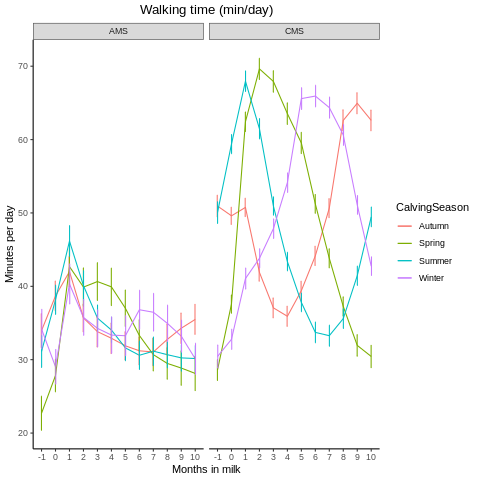

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(MonthsInMilk == max(as.numeric(MonthsInMilk)), as.character(MilkingType,CalvingSeason), NA_character_)) %>%
  ggplot(
  aes(
    x=MonthsInMilk,
    y=lsmean,
    group=CalvingSeason, 
    color=CalvingSeason)
    ) +
  facet_wrap(~MilkingType) + 
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Walking time (min/day)", 
    y="Minutes per day" , 
    x = "Months in milk") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

# Model without 3 way interaction

In [ ]:
%%R
AnalysisDataAMS <- AnalysisData %>% dplyr::filter(MilkingType == "AMS")
AnalysisDataCMS <- AnalysisData %>% dplyr::filter(MilkingType != "AMS")

## MonthsInMilk by calving season AMS

In [ ]:
%%R
ModelAMSOnly <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*CalvingSeason + 
                  MonthsInMilk*Parity + 
                   MonthsInMilk*CalvingSeason + 
                    (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisDataAMS
                  )

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(ModelAMSOnly, pairwise ~ MonthsInMilk|CalvingSeason, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 16514' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 16514)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 16514' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 16514)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



CalvingSeason = Autumn:
 MonthsInMilk lsmean    SE  df asymp.LCL asymp.UCL .group 
 7              31.2 0.741 Inf      29.0      33.3  a     
 6              31.2 0.745 Inf      29.1      33.3  a     
 5              32.0 0.751 Inf      29.9      34.2  ab    
 8              32.9 0.813 Inf      30.6      35.2  abc   
 4              33.0 0.804 Inf      30.7      35.3  abc   
 3              34.1 0.797 Inf      31.8      36.4  abcd  
 9              34.4 0.808 Inf      32.1      36.7   bcd  
 -1             35.1 0.826 Inf      32.7      37.4   bcde 
 10             35.2 0.798 Inf      32.9      37.4    cde 
 2              36.1 0.732 Inf      34.1      38.2     de 
 0              37.8 0.731 Inf      35.7      39.9      e 
 1              42.7 0.759 Inf      40.5      44.9       f

CalvingSeason = Spring:
 MonthsInMilk lsmean    SE  df asymp.LCL asymp.UCL .group 
 -1             22.9 0.882 Inf      20.4      25.5  a     
 10             28.0 0.920 Inf      25.4      30.6   b    
 0     

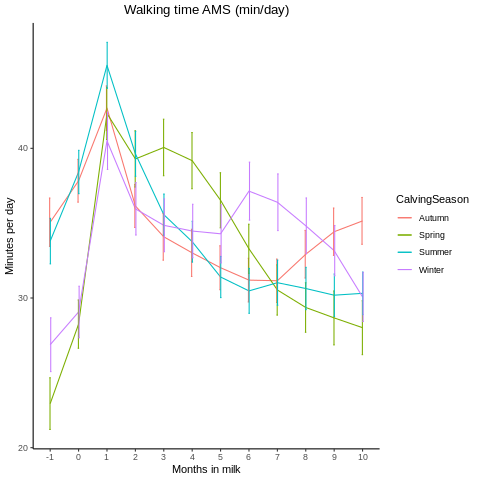

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(MonthsInMilk == max(as.numeric(MonthsInMilk)), as.character(CalvingSeason), NA_character_)) %>%
  ggplot(
  aes(
    x=MonthsInMilk,
    y=lsmean,
    group=CalvingSeason, 
    color=CalvingSeason)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Walking time AMS (min/day)", 
    y="Minutes per day" , 
    x = "Months in milk") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

## MonthsInMilk by calving season CMS

In [ ]:
%%R
ModelCMSOnly <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*CalvingSeason + 
                  MonthsInMilk*Parity + 
                   MonthsInMilk*CalvingSeason + 
                    (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisDataCMS
                  )

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(ModelCMSOnly, pairwise ~ MonthsInMilk|CalvingSeason, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 37559' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 37559)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 37559' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 37559)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



CalvingSeason = Autumn:
 MonthsInMilk lsmean    SE  df asymp.LCL asymp.UCL .group   
 4              36.0 0.735 Inf      33.9      38.1  a       
 3              37.4 0.726 Inf      35.3      39.5  ab      
 5              39.6 0.687 Inf      37.6      41.6   bc     
 2              42.2 0.645 Inf      40.4      44.1    cd    
 6              44.5 0.706 Inf      42.4      46.5     d    
 0              49.6 0.618 Inf      47.8      51.3      e   
 -1             50.7 0.751 Inf      48.5      52.8      e   
 7              50.8 0.698 Inf      48.8      52.8      e   
 1              50.8 0.663 Inf      48.9      52.7      e   
 10             62.0 0.760 Inf      59.8      64.2       f  
 8              62.3 0.777 Inf      60.1      64.6       f  
 9              64.3 0.773 Inf      62.1      66.5       f  

CalvingSeason = Spring:
 MonthsInMilk lsmean    SE  df asymp.LCL asymp.UCL .group   
 -1             29.2 0.757 Inf      27.1      31.4  a       
 10             30.5 0.824 Inf      

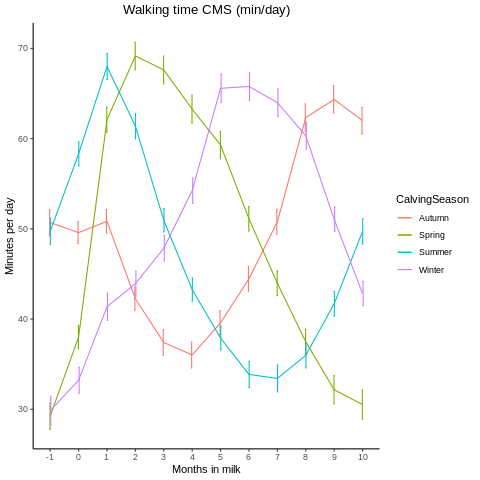

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(MonthsInMilk == max(as.numeric(MonthsInMilk)), as.character(CalvingSeason), NA_character_)) %>%
  ggplot(
  aes(
    x=MonthsInMilk,
    y=lsmean,
    group=CalvingSeason, 
    color=CalvingSeason)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Walking time CMS (min/day)", 
    y="Minutes per day" , 
    x = "Months in milk") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))